# Neural Tangent Kernel Analysis with Finite Width and Depth

This notebook implements a Poisson PDE solver using neural networks with configurable activation functions, and analyzes the NTK behavior.

## 1. Setup and Imports
Make sure to run `pip install -r requirements.txt` before running this notebook.

In [1]:
import sys
import os
import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax
from jax import grad, jacfwd, vmap
import numpy as np
import time
import dill

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import optax
import pandas as pd

from typing import Any, Callable, Sequence, Optional, Union

In [2]:
# importing the analyzer class
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.ntk_analyzer import NTKAnalyzer
from util.helper import create_mlp_stax, create_mlp_stax_2
output_directory = "data/pinn"

In [3]:
# True solution and source term
# u(x,y) = sin(pi x) sin(pi y)
# ∇²u = f, so f = -2 π² sin(pi x) sin(pi y)

def u_true(xy):
    x, y = xy
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

def f_source(xy):
    x, y = xy
    return -2 * (jnp.pi ** 2) * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

In [4]:
INPUT_DIM = 2
OUTPUT_DIM = 1

HIDDEN_LAYERS = 2
HIDDEN_WIDTH = 2**8
ACTIVATION_FN_STAX = stax.Erf()

# for init of weights
W_STD = 1.5            
B_STD = 0.05

# Network Hyperparameters
init_fn, apply_fn, net_stax_kernel_fn = create_mlp_stax(
    depth=HIDDEN_LAYERS, 
    hidden_width=HIDDEN_WIDTH,
    output_dim=OUTPUT_DIM,
    activation_stax_fn=ACTIVATION_FN_STAX,
    W_std=W_STD,
    b_std=B_STD
)

# Initialize params
key = jax.random.PRNGKey(0)
_, init_params = init_fn(key, (-1, INPUT_DIM))

In [5]:
def laplacian_u_stax(params, coords):
    u_fn = lambda z: apply_fn(params, z).squeeze()
    grad_u_hat_fn = jax.grad(u_fn)
    hessian_fn = jax.jacfwd(grad_u_hat_fn)
    hessian = hessian_fn(coords)
    return jnp.trace(hessian)

# Residual at point xy
def pde_residual_stax(params, coords):
    return laplacian_u_stax(params, coords) - f_source(coords)

In [6]:
# Loss computation
boundary_loss_weight = 100.0 # Hyperparameter to balance PDE and boundary losses

def compute_total_loss(params, interior_pts, boundary_pts):
    pde_vals = vmap(lambda pt: pde_residual_stax(params, pt))(interior_pts)
    loss_pde = jnp.mean(pde_vals**2)

    u_boundary = vmap(lambda pt: apply_fn(params, pt))(boundary_pts)
    loss_bc = jnp.mean(u_boundary**2)

    return loss_pde + boundary_loss_weight * loss_bc

# Optimizer
tx = optax.adam(1e-3)
opt_state = tx.init(init_params)

@jax.jit
def train_step_stax(params, opt_state, interior_pts, boundary_pts):
    def loss_fn(p):
        # compute_total_loss already returns a scalar, no squeeze needed.
        return compute_total_loss(p, interior_pts, boundary_pts)
    
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss_val

In [7]:
# Sample points for the 
n_int = 1000    # Number of interior collocation points
n_bnd_side = 500 # Number of boundary points per side
key, k_int, k_bnd_y, k_bnd_x = jax.random.split(key, 4) # New keys

# Sample interior points (domain: unit square [0,1]x[0,1])
interior_points = jax.random.uniform(k_int, (n_int, 2), minval=0., maxval=1.)

# Sample boundary points
rand_ys_for_x_sides = jax.random.uniform(k_bnd_y, (n_bnd_side, 1), minval=0., maxval=1.)
rand_xs_for_y_sides = jax.random.uniform(k_bnd_x, (n_bnd_side, 1), minval=0., maxval=1.)

boundary_points = jnp.vstack([
    jnp.hstack([jnp.zeros((n_bnd_side, 1)), rand_ys_for_x_sides]),   # x=0 edge
    jnp.hstack([jnp.ones((n_bnd_side, 1)), rand_ys_for_x_sides]),    # x=1 edge
    jnp.hstack([rand_xs_for_y_sides, jnp.zeros((n_bnd_side, 1))]),   # y=0 edge
    jnp.hstack([rand_xs_for_y_sides, jnp.ones((n_bnd_side, 1))])     # y=1 edge
])

In [8]:
layer_widths_spec = [INPUT_DIM] + [HIDDEN_WIDTH] * HIDDEN_LAYERS + [OUTPUT_DIM]

# Let us analyze some NTK
analyzer_initial = NTKAnalyzer(
    apply_fn=apply_fn, 
    params=init_params,
    depth=HIDDEN_LAYERS, 
    widths=layer_widths_spec
)

In [9]:
# Training loop
n_epochs = 500

print(f"Starting training")
stax_params = init_params.copy()

for epoch in range(1, n_epochs + 1):

    stax_params, opt_state, loss = train_step_stax(stax_params, opt_state, interior_points, boundary_points)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{n_epochs} loss={loss:.4e}")

print("Training finished.")

Starting training
Epoch 100/500 loss=1.4804e+01
Epoch 200/500 loss=6.7609e+00
Epoch 300/500 loss=4.4067e+00
Epoch 400/500 loss=3.6212e+00
Epoch 500/500 loss=3.2388e+00
Training finished.


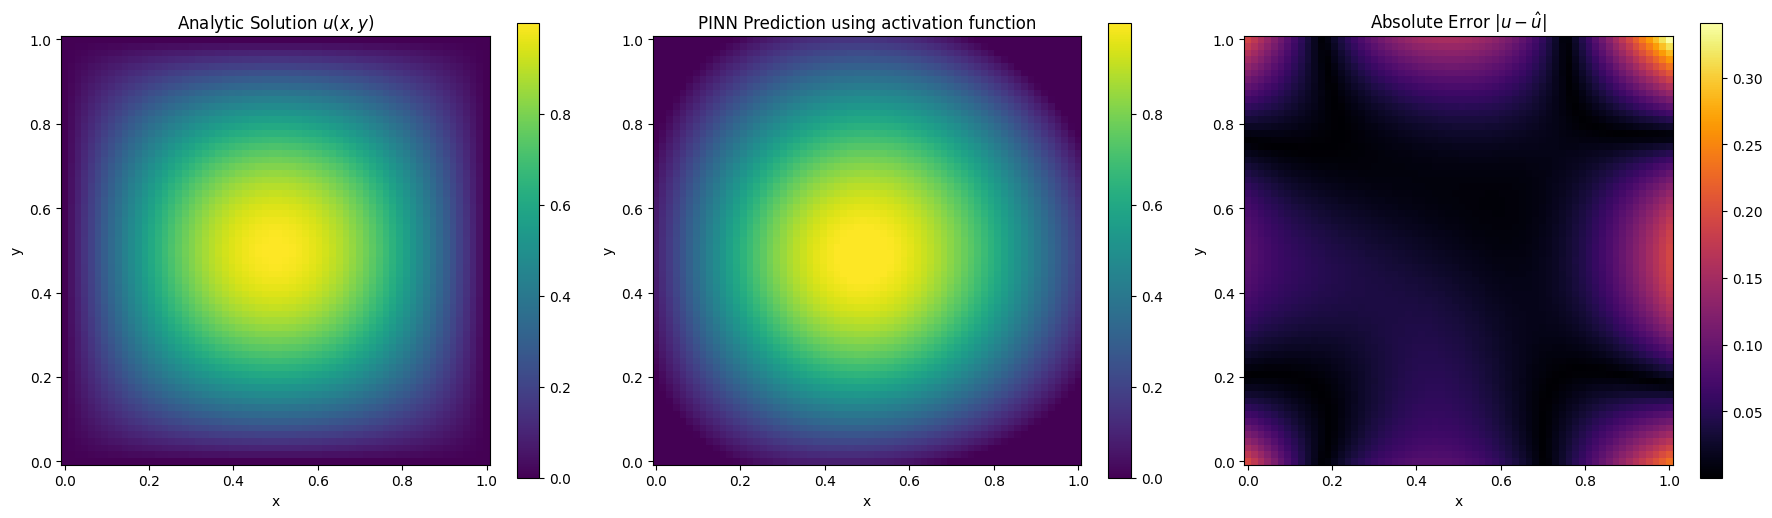

L2 Relative Error: 1.2109e-01


In [10]:
# Evaluation and Plotting
grid_n = 64
t = jnp.linspace(0, 1, grid_n)
xx, yy = jnp.meshgrid(t, t)
# pts will have shape (grid_n*grid_n, 2)
pts_flat = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

# True solution values
u_true_on_grid = vmap(u_true)(pts_flat).reshape((grid_n, grid_n))

# Predicted solution values
# vmap mlp_predict over all points in pts_flat
u_pred_on_grid = vmap(lambda single_pt: apply_fn(stax_params, single_pt))(pts_flat).reshape((grid_n, grid_n))

# Error
error_on_grid = jnp.abs(u_true_on_grid - u_pred_on_grid)

# Plotting
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.pcolormesh(xx, yy, u_true_on_grid, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('Analytic Solution $u(x,y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')

plt.subplot(1, 3, 2)
plt.pcolormesh(xx, yy, u_pred_on_grid, shading='auto', cmap='viridis', vmin=u_true_on_grid.min(), vmax=u_true_on_grid.max()) # same color scale
plt.colorbar()
plt.title(f'PINN Prediction using activation function')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')

plt.subplot(1, 3, 3)
plt.pcolormesh(xx, yy, error_on_grid, shading='auto', cmap='inferno')
plt.colorbar()
plt.title('Absolute Error $|u - \hat{u}|$')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')

plt.tight_layout()
plt.show()

# Calculate L2 relative error
l2_error_numerator = jnp.sqrt(jnp.sum((u_true_on_grid - u_pred_on_grid)**2))
l2_error_denominator = jnp.sqrt(jnp.sum(u_true_on_grid**2))
l2_relative_error = l2_error_numerator / l2_error_denominator
print(f"L2 Relative Error: {l2_relative_error:.4e}")

# 2. FINITE Width Analysis

In [11]:
ACTIVATION_FUNCTIONS = {
    "ReLU": stax.Relu(),
    "Sigmoid_like": stax.Sigmoid_like(),
    "Gelu": stax.Gelu()
}

CURRENT_ACTIVATION = "Gelu"

network_configurations = [
    # Group 1: Fixed Width, Varying Depth
    # W = 16
    {"name": "D1_W16",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/1 = 17.0
    {"name": "D2_W16",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/2 = 8.5
    {"name": "D4_W16",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/4 = 4.25
    {"name": "D8_W16",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/8 = 2.125
    {"name": "D16_W16",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/16 = 1.0625
    {"name": "D32_W16",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/32 = 0.53125
    {"name": "D48_W16",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/48 = 0.3541666666666667
    {"name": "D64_W16",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/64 = 0.265625

    # W = 32
    {"name": "D1_W32",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/1 = 33.0
    {"name": "D2_W32",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/2 = 16.5
    {"name": "D3_W32",   "HIDDEN_LAYERS": 3,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/3 = 11.0
    {"name": "D4_W32",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/4 = 8.25
    {"name": "D6_W32",   "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/6 = 5.5
    {"name": "D8_W32",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/8 = 4.125
    {"name": "D10_W32",  "HIDDEN_LAYERS": 10,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/10 = 3.3
    {"name": "D16_W32",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/16 = 2.0625
    {"name": "D24_W32",  "HIDDEN_LAYERS": 24,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/24 = 1.375
    {"name": "D32_W32",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/32 = 1.03125
    {"name": "D40_W32",  "HIDDEN_LAYERS": 40,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/40 = 0.825
    {"name": "D48_W32",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/48 = 0.6875
    {"name": "D64_W32",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/64 = 0.515625

    # W = 64
    {"name": "D1_W64",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/1 = 65.0
    {"name": "D2_W64",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/2 = 32.5
    {"name": "D3_W64",   "HIDDEN_LAYERS": 3,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/3 = 21.666666666666668
    {"name": "D4_W64",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/4 = 16.25
    {"name": "D6_W64",   "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/6 = 10.833333333333334
    {"name": "D8_W64",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/8 = 8.125
    {"name": "D12_W64",  "HIDDEN_LAYERS": 12,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/12 = 5.416666666666667
    {"name": "D16_W64",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/16 = 4.0625
    {"name": "D24_W64",  "HIDDEN_LAYERS": 24,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/24 = 2.7083333333333335
    {"name": "D32_W64",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/32 = 2.03125
    {"name": "D48_W64",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/48 = 1.3541666666666667
    {"name": "D64_W64",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/64 = 1.015625
    {"name": "D80_W64",  "HIDDEN_LAYERS": 80,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/80 = 0.8125
    {"name": "D96_W64",  "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/96 = 0.6770833333333334

    # W = 128
    {"name": "D1_W128",  "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/1 = 129.0
    {"name": "D2_W128",  "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/2 = 64.5
    {"name": "D4_W128",  "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/4 = 32.25
    {"name": "D6_W128",  "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/6 = 21.5
    {"name": "D8_W128",  "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/8 = 16.125
    {"name": "D12_W128", "HIDDEN_LAYERS": 12,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/12 = 10.75
    {"name": "D16_W128", "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/16 = 8.0625
    {"name": "D32_W128", "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/32 = 4.03125
    {"name": "D64_W128", "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/64 = 2.015625
    {"name": "D96_W128", "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/96 = 1.34375
    {"name": "D128_W128","HIDDEN_LAYERS": 128, "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/128 = 1.0078125

    # W = 256
    {"name": "D1_W256",  "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/1 = 257.0
    {"name": "D2_W256",  "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/2 = 128.5
    {"name": "D4_W256",  "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/4 = 64.25
    {"name": "D8_W256",  "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/8 = 32.125
    {"name": "D16_W256", "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/16 = 16.0625
    {"name": "D32_W256", "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/32 = 8.03125
    {"name": "D64_W256", "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/64 = 4.015625
    {"name": "D96_W256", "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/96 = 2.6770833333333335
    {"name": "D192_W256","HIDDEN_LAYERS": 192, "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/192 = 1.3385416666666667

    # Group 2: Fixed Depth, Varying Width
    # D = 1
    # {"name": "D1_W32",   "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 32,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/1 = 33.0 (duplicate, commented out)
    # {"name": "D1_W64",   "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 64,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/1 = 65.0 (duplicate, commented out)
    # {"name": "D1_W128",  "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 128,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/1 = 129.0 (duplicate, commented out)
    # {"name": "D1_W256",  "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 256,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/1 = 257.0 (duplicate, commented out)
    {"name": "D1_W512",  "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (512+1)/1 = 513.0
    {"name": "D1_W1024", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (1024+1)/1 = 1025.0
    {"name": "D1_W2048", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (2048+1)/1 = 2049.0
    {"name": "D1_W4096", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (4096+1)/1 = 4097.0

    # D = 2
    # {"name": "D2_W16",   "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 16,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/2 = 8.5 (duplicate, commented out)
    # {"name": "D2_W32",   "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 32,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/2 = 16.5 (duplicate, commented out)
    # {"name": "D2_W64",   "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 64,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/2 = 32.5 (duplicate, commented out)
    # {"name": "D2_W128",  "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 128,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/2 = 64.5 (duplicate, commented out)
    # {"name": "D2_W256",  "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 256,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/2 = 128.5 (duplicate, commented out)
    {"name": "D2_W512",  "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (512+1)/2 = 256.5
    {"name": "D2_W1024", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (1024+1)/2 = 512.5
    {"name": "D2_W2048", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (2048+1)/2 = 1024.5
    {"name": "D2_W4096", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (4096+1)/2 = 2048.5

    # D = 4
    # {"name": "D4_W16",   "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 16,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/4 = 4.25 (duplicate, commented out)
    # {"name": "D4_W32",   "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 32,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/4 = 8.25 (duplicate, commented out)
    # {"name": "D4_W64",   "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 64,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/4 = 16.25 (duplicate, commented out)
    # {"name": "D4_W128",  "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 128,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/4 = 32.25 (duplicate, commented out)
    # {"name": "D4_W256",  "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 256,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/4 = 64.25 (duplicate, commented out)
    {"name": "D4_W512",  "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (512+1)/4 = 128.25
    {"name": "D4_W1024", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (1024+1)/4 = 256.25
    {"name": "D4_W2048", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (2048+1)/4 = 512.25
    {"name": "D4_W4096", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (4096+1)/4 = 1024.25

    # D = 8
    # {"name": "D8_W16",   "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 16,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/8 = 2.125 (duplicate, commented out)
    # {"name": "D8_W32",   "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 32,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/8 = 4.125 (duplicate, commented out)
    # {"name": "D8_W64",   "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 64,   "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/8 = 8.125 (duplicate, commented out)
    # {"name": "D8_W128",  "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 128,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/8 = 16.125 (duplicate, commented out)
    # {"name": "D8_W256",  "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 256,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/8 = 32.125 (duplicate, commented out)
    {"name": "D8_W512",  "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (512+1)/8 = 64.125
    {"name": "D8_W1024", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (1024+1)/8 = 128.125
    {"name": "D8_W2048", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (2048+1)/8 = 256.125
    {"name": "D8_W4096", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (4096+1)/8 = 512.125

    # D = 16
    # {"name": "D16_W16",  "HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (16+1)/16 = 1.0625 (duplicate, commented out)
    # {"name": "D16_W32",  "HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (32+1)/16 = 2.0625 (duplicate, commented out)
    # {"name": "D16_W64",  "HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (64+1)/16 = 4.0625 (duplicate, commented out)
    # {"name": "D16_W128", "HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (128+1)/16 = 8.0625 (duplicate, commented out)
    # {"name": "D16_W256", "HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (256+1)/16 = 16.0625 (duplicate, commented out)
    {"name": "D16_W512", "HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 512, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (512+1)/16 = 32.0625
    {"name": "D16_W1024","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (1024+1)/16 = 64.0625
    {"name": "D16_W2048","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (2048+1)/16 = 128.0625
    {"name": "D16_W4096","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (4096+1)/16 = 256.0625

    # D = 32
    {"name": "D32_W512", "HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (512+1)/32 = 16.03125
    {"name": "D32_W1024","HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (1024+1)/32 = 32.03125
    {"name": "D32_W2048","HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = (2048+1)/32 = 64.03125
]

# Choose a single data point
x_single_point_for_analysis = interior_points[0:1, :]
x_norm_sq = jnp.linalg.norm(x_single_point_for_analysis.squeeze())**2 
n0 = INPUT_DIM # Input dimension

# For verifying Theorem 2
y_star_for_sgd_step = u_pred_on_grid[0:1, :] # Target for the chosen x_single_point
learning_rate_sgd = 1e-3 # Learning rate for the single SGD step

num_initializations_for_verification = 100

print(f"Will analyze {len(network_configurations)} network configurations.")
print(f"Using x_single_point: {x_single_point_for_analysis.squeeze()}, ||x||^2: {x_norm_sq:.4f}")
print(f"Input dimension n0 (INPUT_DIM): {n0}")
print(f"Number of random initializations for averaging: {num_initializations_for_verification}")

# List to store results from all configurations
relu_result = []

# Main PRNG key for this loop of experiments
main_exp_key = jax.random.PRNGKey(789)

def mse_loss_single_point_fn(params_current, x_batch, y_batch, apply_fn_local):
    y_pred = apply_fn_local(params_current, x_batch)
    if y_pred.shape != y_batch.shape and y_pred.shape[-1] == y_batch.shape[-1]:
        y_pred = y_pred.reshape(y_batch.shape)
    return 0.5 * jnp.sum((y_pred - y_batch)**2) # Sum for scalar loss

Will analyze 78 network configurations.
Using x_single_point: [0.00729382 0.02089119], ||x||^2: 0.0005
Input dimension n0 (INPUT_DIM): 2
Number of random initializations for averaging: 100


# 3. Experiments: To Infinity and Beyond

In [22]:
for config_idx, config in enumerate(network_configurations):
    print(f"\n--- Processing Configuration {config_idx+1}/{len(network_configurations)}: {config['name']} ---")
    start_time_config = time.time()

    current_hidden_layers = config["HIDDEN_LAYERS"]
    current_hidden_width = config["HIDDEN_WIDTH"]
    current_activation_fn = config["ACTIVATION_FN_STAX"]
    current_w_std = config["W_STD"]
    current_b_std = config["B_STD"]

    init_fn_config, apply_fn_config, _, layer_widths_config = create_mlp_stax_2(
        depth_hidden=current_hidden_layers,
        hidden_width=current_hidden_width,
        output_dim=OUTPUT_DIM, 
        input_dim=INPUT_DIM,   
        activation_stax_fn=current_activation_fn,
        W_std=current_w_std,
        b_std=current_b_std
    )

    effective_depth_d_config = current_hidden_layers + 1
    
    beta = None
    if layer_widths_config and len(layer_widths_config) > 2:
        hidden_widths_config = layer_widths_config[1:-1]
        if hidden_widths_config:
            beta = sum(1.0 / w for w in hidden_widths_config if w > 0)
    
    beta_print_str = f"{beta:.4f}" if beta is not None else "N/A"
    print(f"  Config: Hidden Layers={current_hidden_layers}, Width={current_hidden_width}, Beta={beta_print_str}")

    k_xx_values_current_config = []
    delta_k_xx_values_current_config = []

    config_prng_key, main_exp_key = jax.random.split(main_exp_key) 

    for i_init in range(num_initializations_for_verification):
        iter_key, config_prng_key = jax.random.split(config_prng_key) 
        _, params_t0 = init_fn_config(iter_key, (-1, INPUT_DIM))
        
        analyzer = NTKAnalyzer(
            apply_fn=apply_fn_config, 
            params=params_t0,
            depth=current_hidden_layers, 
            widths=layer_widths_config
        )
        
        diag_val_obj_t0 = analyzer.get_ntk_diagonal_per_output(x_single_point_for_analysis)
        if diag_val_obj_t0 is None:
            print(f"    Warning: Could not get K(x,x) for init {i_init+1}")
            continue 
        
        k_t0_xx = diag_val_obj_t0[0, 0].item()
        k_xx_values_current_config.append(k_t0_xx)
        
        loss_fn_single_for_grad_config = jax.tree_util.Partial(mse_loss_single_point_fn, apply_fn_local=apply_fn_config)
        grad_fn_single_config = jax.grad(loss_fn_single_for_grad_config)

        grads_t0 = grad_fn_single_config(params_t0, x_single_point_for_analysis, y_star_for_sgd_step)
        params_t1 = jax.tree_util.tree_map(lambda p, g: p - learning_rate_sgd * g, params_t0, grads_t0)
        
        diag_val_obj_t1 = analyzer.get_ntk_diagonal_per_output(x_single_point_for_analysis, params_override=params_t1)
        if diag_val_obj_t1 is None:
            print(f"    Warning: Could not get K(x,x) after SGD step for init {i_init+1}")
            continue

        k_t1_xx = diag_val_obj_t1[0, 0].item()
        delta_k_xx_values_current_config.append(k_t1_xx - k_t0_xx)

    config_results = {"config_name": config["name"], "config_details": config, "beta": beta}
    
    if k_xx_values_current_config:
        k_xx_arr = jnp.array(k_xx_values_current_config)
        emp_E_Kxx = jnp.mean(k_xx_arr)
        emp_E_Kxx_sq = jnp.mean(k_xx_arr**2)
        emp_Var_Kxx = jnp.var(k_xx_arr)
        
        config_results["emp_E_Kxx"] = emp_E_Kxx.item()
        config_results["emp_E_Kxx_sq"] = emp_E_Kxx_sq.item()
        config_results["emp_Var_Kxx"] = emp_Var_Kxx.item()
        
        if emp_E_Kxx**2 != 0:
            emp_norm_sq_moment = emp_E_Kxx_sq / (emp_E_Kxx**2)
            config_results["emp_norm_sq_moment"] = emp_norm_sq_moment.item() 
            config_results["emp_sq_coeff_var"] = emp_norm_sq_moment.item() - 1 
        else:
            config_results["emp_norm_sq_moment"] = jnp.nan
            config_results["emp_sq_coeff_var"] = jnp.nan

        is_relu_activation_config = (config.get("ACTIVATION_NAME") == "ReLU")
        
        bias_contrib = 0.5 if config["B_STD"] > 1e-6 and is_relu_activation_config else 0.0

        # compute theoritical results
        theo_E_Kxx_relu = effective_depth_d_config * (bias_contrib + x_norm_sq / n0)
        config_results["theo_E_Kxx_relu_formula"] = theo_E_Kxx_relu.item()
        print(f"  Empirical E[K(x,x)]: {emp_E_Kxx:.4f} (Theoretical for ReLU: {theo_E_Kxx_relu:.4f})")
    else:
        print("  No K(x,x) values collected for this config.")

    if delta_k_xx_values_current_config:
        delta_k_xx_arr = jnp.array(delta_k_xx_values_current_config)
        emp_E_Delta_Kxx = jnp.mean(delta_k_xx_arr)
        config_results["emp_E_Delta_Kxx"] = emp_E_Delta_Kxx.item()
        print(f"  Empirical E[Delta K(x,x)]: {emp_E_Delta_Kxx:.6e}")
        if "emp_E_Kxx" in config_results and config_results["emp_E_Kxx"] !=0 :
            emp_relative_delta_K = emp_E_Delta_Kxx / config_results["emp_E_Kxx"]
            config_results["emp_relative_delta_K"] = emp_relative_delta_K.item()
            print(f"  Empirical Relative E[Delta K]/E[K]: {emp_relative_delta_K:.6e}")
            C_factor_hn = 5.0 # for ReLU
            if beta is not None and is_relu_activation_config : 
                 theoretical_scaling_term_delta_K = effective_depth_d_config * beta / n0 * jnp.exp(C_factor_hn * beta) * learning_rate_sgd
                 config_results["theo_scaling_term_delta_K_relu"] = theoretical_scaling_term_delta_K.item()
                 print(f"    Theoretical scaling term for Delta K (d*beta/n0 * exp(C*beta) * lr, C={C_factor_hn}): {theoretical_scaling_term_delta_K:.4e}")
    else:
        print("  No Delta K(x,x) values collected for this config.")
        
        
    relu_result.append(config_results)
    end_time_config = time.time()
    print(f"  Finished processing config {config['name']} in {end_time_config - start_time_config:.2f} seconds.")

loaded_results_df = pd.DataFrame(relu_result)
print("\n--- Summary of Results ---")
# display(loaded_results_df)


--- Processing Configuration 1/78: D1_W16 ---
  Config: Hidden Layers=1, Width=16, Beta=0.0625
  Empirical E[K(x,x)]: 0.0002 (Theoretical for ReLU: 0.0005)
  Empirical E[Delta K(x,x)]: -1.791341e-10
  Empirical Relative E[Delta K]/E[K]: -7.463008e-07
  Finished processing config D1_W16 in 4.29 seconds.

--- Processing Configuration 2/78: D2_W16 ---
  Config: Hidden Layers=2, Width=16, Beta=0.1250
  Empirical E[K(x,x)]: 0.0002 (Theoretical for ReLU: 0.0007)
  Empirical E[Delta K(x,x)]: -2.956585e-10
  Empirical Relative E[Delta K]/E[K]: -1.589700e-06
  Finished processing config D2_W16 in 3.15 seconds.

--- Processing Configuration 3/78: D4_W16 ---
  Config: Hidden Layers=4, Width=16, Beta=0.2500
  Empirical E[K(x,x)]: 0.0001 (Theoretical for ReLU: 0.0012)
  Empirical E[Delta K(x,x)]: -1.411899e-10
  Empirical Relative E[Delta K]/E[K]: -1.916726e-06
  Finished processing config D4_W16 in 4.96 seconds.

--- Processing Configuration 4/78: D8_W16 ---
  Config: Hidden Layers=8, Width=16, B

In [27]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created directory: {output_directory}")

base_filename = "pinn-gelu-24-05-01.dill.pkl"
pickle_filename = os.path.join(output_directory, base_filename)

with open(pickle_filename, 'wb') as f:
    dill.dump(loaded_results_df, f)
print(f"Results saved to {pickle_filename}")

Results saved to data/gelu-24-05-01.dill.pkl


### Loading existing results

In [12]:
base_filename = "pinn-relu-24-05-01.dill.pkl"
pickle_filename = os.path.join(output_directory, base_filename)

loaded_results_df = None
try:
    with open(pickle_filename, 'rb') as f:
        loaded_results_df = dill.load(f)
except Exception as e:
    print(e)

relu_result = loaded_results_df
display(relu_result)

,config_name,config_details,beta,emp_E_Kxx,emp_E_Kxx_sq,emp_Var_Kxx,emp_norm_sq_moment,emp_sq_coeff_var,theo_E_Kxx_relu_formula,emp_E_Delta_Kxx,emp_relative_delta_K,theo_scaling_term_delta_K_relu
0,D1_W16,"{'name': 'D1_W16', 'HIDDEN_LAYERS': 1, 'HIDDEN...",0.062500,1.934469,4.332849,0.590680,1.157844,0.157844,2.0,-0.000417,-0.000216,0.000171
1,D2_W16,"{'name': 'D2_W16', 'HIDDEN_LAYERS': 2, 'HIDDEN...",0.125000,2.974763,13.484859,4.635643,1.523848,0.523848,3.0,-0.002070,-0.000696,0.000701
2,D4_W16,"{'name': 'D4_W16', 'HIDDEN_LAYERS': 4, 'HIDDEN...",0.250000,4.800024,50.486523,27.446297,2.191234,1.191234,5.0,-0.010216,-0.002128,0.004363
3,D8_W16,"{'name': 'D8_W16', 'HIDDEN_LAYERS': 8, 'HIDDEN...",0.500000,8.803933,605.489807,527.980530,7.811841,6.811841,9.0,-0.270672,-0.030744,0.054821
4,D16_W16,"{'name': 'D16_W16', 'HIDDEN_LAYERS': 16, 'HIDD...",1.000000,14.316003,1980.961792,1776.013916,9.665683,8.665683,17.0,-1.556889,-0.108752,2.523024
...,...,...,...,...,...,...,...,...,...,...,...,...
73,D16_W2048,"{'name': 'D16_W2048', 'HIDDEN_LAYERS': 16, 'HI...",0.007812,17.107147,303.541504,10.886982,1.037201,0.037201,17.0,-0.050646,-0.002961,0.000138
74,D16_W4096,"{'name': 'D16_W4096', 'HIDDEN_LAYERS': 16, 'HI...",0.003906,17.002926,292.784668,3.685158,1.012747,0.012747,17.0,-0.035067,-0.002062,0.000068
75,D32_W512,"{'name': 'D32_W512', 'HIDDEN_LAYERS': 32, 'HID...",0.062500,30.224493,1173.032837,259.512787,1.284080,0.284080,33.0,-1.071251,-0.035443,0.002819
76,D32_W1024,"{'name': 'D32_W1024', 'HIDDEN_LAYERS': 32, 'HI...",0.031250,33.505867,1261.148193,138.505005,1.123374,0.123374,33.0,-1.163518,-0.034726,0.001206


## Plotting results

### ReLU

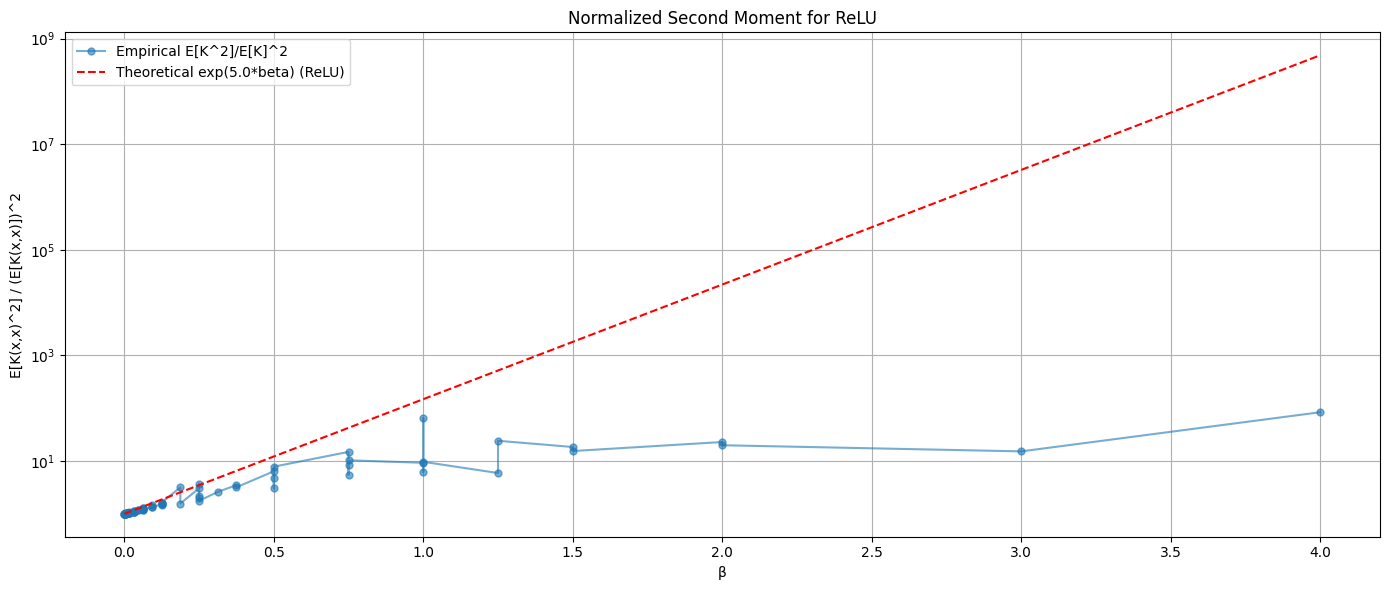

In [13]:
# --- Plot for Stochasticity: E[K^2]/E[K]^2 vs. beta ---
plot_data_stochasticity = []
# Iterate over DataFrame rows as dictionaries
for res_stoch in relu_result.to_dict('records'): 
    beta_val = res_stoch.get("beta")
    emp_norm_sq_moment_val = res_stoch.get("emp_norm_sq_moment")
    
    if beta_val is not None and \
       emp_norm_sq_moment_val is not None and \
       not (isinstance(emp_norm_sq_moment_val, float) and pd.isna(emp_norm_sq_moment_val)): # Use pd.isna for DataFrames
        
        activation_name_stoch = "Unknown"
        config_details_stoch = res_stoch.get("config_details")
        if isinstance(config_details_stoch, dict):
            activation_name_stoch = config_details_stoch.get("ACTIVATION_NAME", "Unknown")

        plot_data_stochasticity.append({
            "beta": beta_val, 
            "emp_norm_sq_moment": emp_norm_sq_moment_val,
            "config_name": res_stoch.get("config_name", "N/A"),
            "activation_name": activation_name_stoch
        })

plot_df_stochasticity = pd.DataFrame(plot_data_stochasticity)
plot_df_stochasticity = plot_df_stochasticity.sort_values(by="beta")

plt.figure(figsize=(14, 6))

plt.plot(plot_df_stochasticity["beta"].values, 
         plot_df_stochasticity["emp_norm_sq_moment"].values, 
         "o-", markersize=5, alpha=0.6, label="Empirical E[K^2]/E[K]^2")

relu_plot_df_stoch = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == "ReLU"]
if not relu_plot_df_stoch.empty:
    C_factor_hn = 5.0 
    betas_for_relu_plot_stoch = jnp.array(relu_plot_df_stoch["beta"].values)
    if betas_for_relu_plot_stoch.size > 0:
        theo_scaling_relu = jnp.exp(C_factor_hn * betas_for_relu_plot_stoch)
        plt.plot(betas_for_relu_plot_stoch, 
                 theo_scaling_relu, 
                 "--", color='red', 
                 label=f"Theoretical exp({C_factor_hn}*beta) (ReLU)")

plt.xlabel("β")
plt.ylabel("E[K(x,x)^2] / (E[K(x,x)])^2")
plt.title("Normalized Second Moment for ReLU")
plt.legend()
plt.grid(True, which="both")
plt.yscale('log')

plt.tight_layout()
plt.show()

### Other activations

In [14]:
files = {
    "ReLU": "pinn-relu-24-05-01.dill.pkl",
    "GeLU": "pinn-gelu-24-05-01.dill.pkl",
    "sigmoid": "pinn-sigmoid-24-05-01.dill.pkl"
}

plot_data_stochasticity = []
for activation, filename in files.items():
    pickle_filename = os.path.join(output_directory, filename)
    loaded_results_df = None
    try:
        with open(pickle_filename, 'rb') as f:
            loaded_results_df = dill.load(f)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        continue
        
    for res_stoch in loaded_results_df.to_dict('records'):
        beta_val = res_stoch.get("beta")
        emp_norm_sq_moment_val = res_stoch.get("emp_norm_sq_moment")
        
        if (beta_val is not None and
            emp_norm_sq_moment_val is not None and
            not (isinstance(emp_norm_sq_moment_val, float) and pd.isna(emp_norm_sq_moment_val))):
            
            activation_name_stoch = activation 
            config_details_stoch = res_stoch.get("config_details")
            if isinstance(config_details_stoch, dict):
                # Override with config_details if available
                activation_name_stoch = config_details_stoch.get("ACTIVATION_NAME", activation)

            plot_data_stochasticity.append({
                "beta": beta_val,
                "emp_norm_sq_moment": emp_norm_sq_moment_val,
                "config_name": res_stoch.get("config_name", "N/A"),
                "activation_name": activation_name_stoch
            })

plot_df_stochasticity = pd.DataFrame(plot_data_stochasticity)
plot_df_stochasticity = plot_df_stochasticity.sort_values(by="beta")

display(plot_df_stochasticity)

,beta,emp_norm_sq_moment,config_name,activation_name
58,0.000244,1.000829,D1_W4096,ReLU
203,0.000244,1.000161,D1_W4096,Sigmoid_like
125,0.000244,1.000286,D1_W4096,Gelu
62,0.000488,1.001228,D2_W4096,ReLU
202,0.000488,1.000174,D1_W2048,Sigmoid_like
...,...,...,...,...
84,3.000000,12.954347,D48_W16,Gelu
151,3.000000,1.018831,D48_W16,Sigmoid_like
6,3.000000,15.229124,D48_W16,ReLU
7,4.000000,83.989090,D64_W16,ReLU


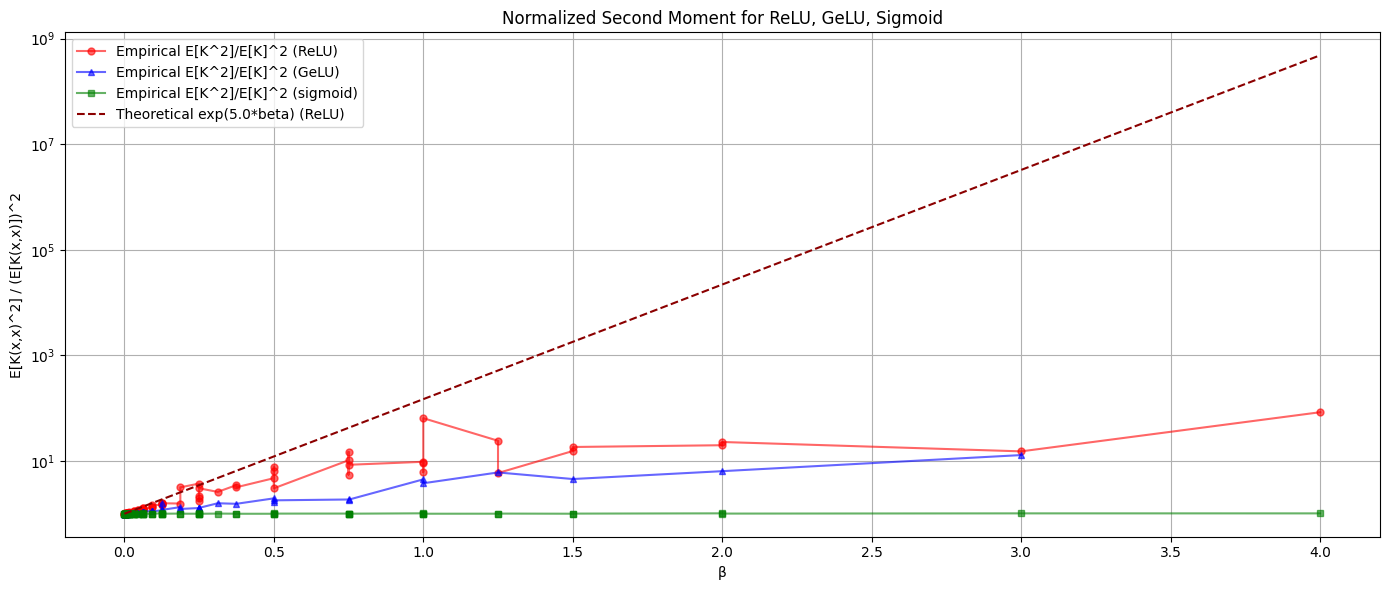

In [15]:
activation_styles = {
    "ReLU": {"color": "red", "marker": "o", "label": "ReLU"},
    "Gelu": {"color": "blue", "marker": "^", "label": "GeLU"},
    "Sigmoid_like": {"color": "green", "marker": "s", "label": "sigmoid"}
}

# Plotting
plt.figure(figsize=(14, 6))

# Subplot 1: Normalized Second Moment
for activation in activation_styles:
    df_subset = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == activation]
    if not df_subset.empty:
        plt.plot(
            df_subset["beta"].values,
            df_subset["emp_norm_sq_moment"].values,
            marker=activation_styles[activation]["marker"],
            color=activation_styles[activation]["color"],
            markersize=5,
            alpha=0.6,
            label=f"Empirical E[K^2]/E[K]^2 ({activation_styles[activation]['label']})"
        )

# Add theoretical curve for ReLU
relu_plot_df_stoch = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == "ReLU"]
if not relu_plot_df_stoch.empty:
    C_factor_hn = 5.0
    betas_for_relu_plot_stoch = jnp.array(relu_plot_df_stoch["beta"].values)
    if betas_for_relu_plot_stoch.size > 0:
        theo_scaling_relu = jnp.exp(C_factor_hn * betas_for_relu_plot_stoch)
        plt.plot(
            betas_for_relu_plot_stoch,
            theo_scaling_relu,
            "--",
            color='darkred',
            label=f"Theoretical exp({C_factor_hn}*beta) (ReLU)"
        )

plt.xlabel("β")
plt.ylabel("E[K(x,x)^2] / (E[K(x,x)])^2")
plt.title("Normalized Second Moment for ReLU, GeLU, Sigmoid")
plt.legend()
plt.grid(True, which="both")
plt.yscale('log')

plt.tight_layout()
plt.show()

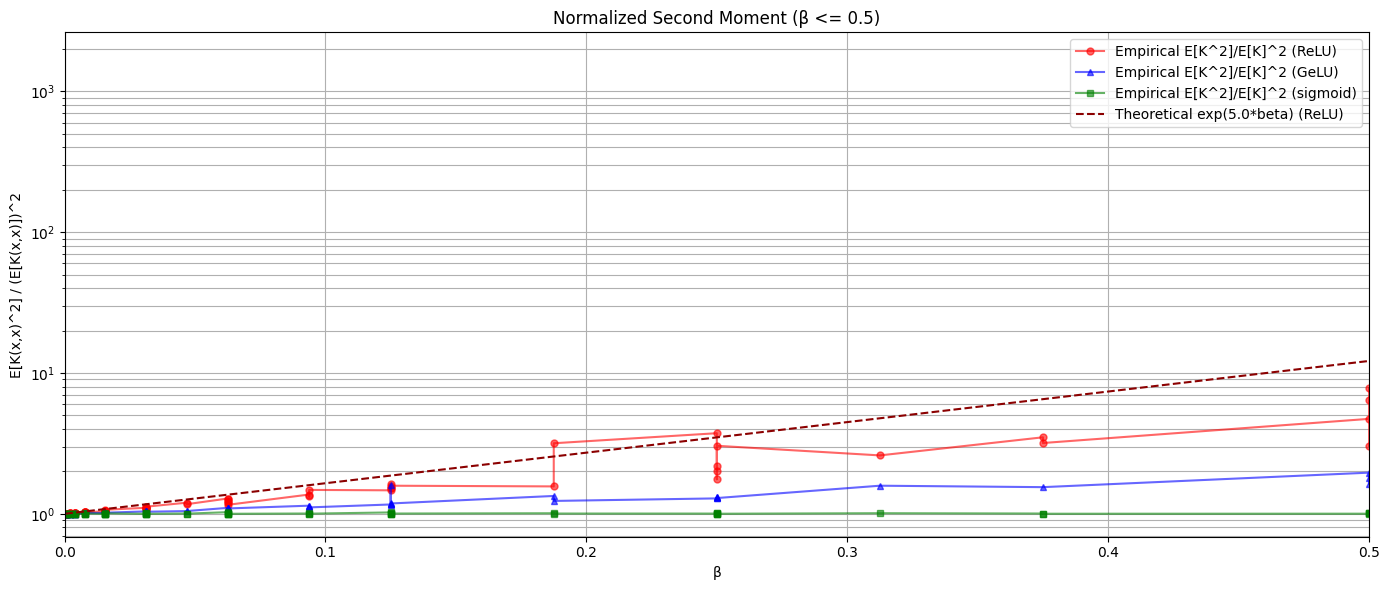

In [16]:
plt.figure(figsize=(14, 6))
BETA_THRES = 0.5

for activation in activation_styles:
    df_subset = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == activation]
    df_subset_zoomed = df_subset[df_subset["beta"] <= BETA_THRES]
    if not df_subset_zoomed.empty:
        plt.plot(
            df_subset_zoomed["beta"].values,
            df_subset_zoomed["emp_norm_sq_moment"].values,
            marker=activation_styles[activation]["marker"],
            color=activation_styles[activation]["color"],
            markersize=5,
            alpha=0.6,
            label=f"Empirical E[K^2]/E[K]^2 ({activation_styles[activation]['label']})"
        )

# Add theoretical curve for ReLU (zoomed)
relu_plot_df_stoch = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == "ReLU"]
relu_plot_df_stoch_zoomed = relu_plot_df_stoch[relu_plot_df_stoch["beta"] <= 1.5]
if not relu_plot_df_stoch_zoomed.empty:
    C_factor_hn = 5.0
    betas_for_relu_plot_stoch = jnp.array(relu_plot_df_stoch_zoomed["beta"].values)
    if betas_for_relu_plot_stoch.size > 0:
        theo_scaling_relu = jnp.exp(C_factor_hn * betas_for_relu_plot_stoch)
        plt.plot(
            betas_for_relu_plot_stoch,
            theo_scaling_relu,
            "--",
            color='darkred',
            label=f"Theoretical exp({C_factor_hn}*beta) (ReLU)"
        )

plt.xlabel("β")
plt.ylabel("E[K(x,x)^2] / (E[K(x,x)])^2")
plt.title(f"Normalized Second Moment (β <= {BETA_THRES})")
plt.legend()
plt.grid(True, which="both")
plt.yscale('log')
plt.xlim(0, BETA_THRES)

plt.tight_layout()
plt.show()

In [17]:
activations = ["ReLU", "Gelu", "Sigmoid_like"]

for activation in activations:
    df_subset = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == activation]
    if not df_subset.empty:
        activation_max = df_subset["emp_norm_sq_moment"].max()
        activation_min = df_subset["emp_norm_sq_moment"].min()
    else:
        activation_max = activation_min = None
    
    print(f"{activation} Values:")
    print(f"Max: {activation_max}")
    print(f"Min: {activation_min}")
    print()

ReLU Values:
Max: 83.98908996582031
Min: 1.0008286237716675

Gelu Values:
Max: 12.954346656799316
Min: 1.000286340713501

Sigmoid_like Values:
Max: 1.026949167251587
Min: 1.0000667572021484



### Thereom II


--- Plotting NTK Evolution: Relative Change vs. Theoretical Scaling ---
Number of ReLU configurations with valid data for Delta K plot: 78
Data for Delta K plot (first 5 rows):


,beta,emp_relative_delta_K,theo_scaling_term_delta_K_relu,config_name
0,0.0625,-0.000216,0.000171,D1_W16
1,0.1250,-0.000696,0.000701,D2_W16
2,0.2500,-0.002128,0.004363,D4_W16
3,0.5000,-0.030744,0.054821,D8_W16
4,1.0000,-0.108752,2.523024,D16_W16


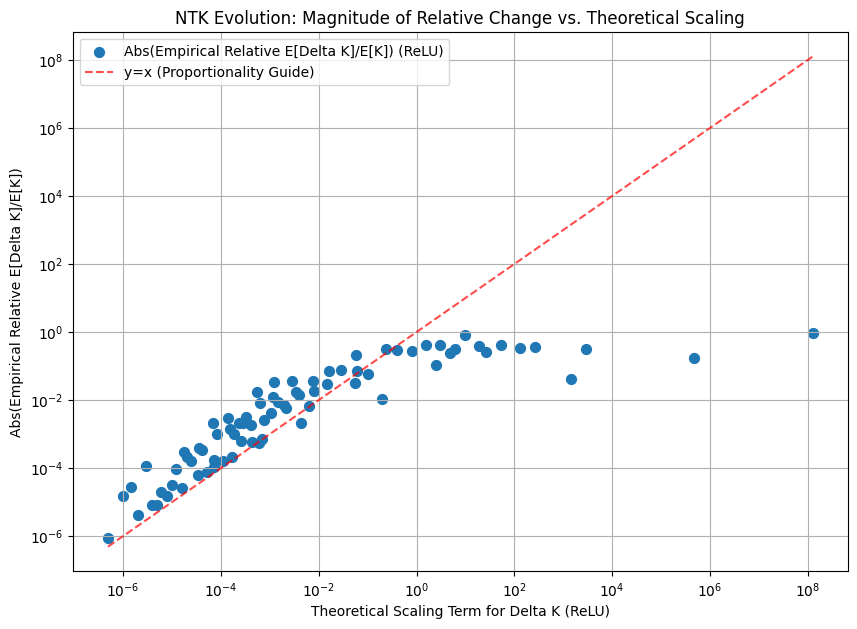

In [20]:
# --- Plot for NTK Evolution: E[Delta K]/E[K] vs theoretical scaling term ---
print("\n--- Plotting NTK Evolution: Relative Change vs. Theoretical Scaling ---")
plot_data_delta_k = []
# Iterate over DataFrame rows as dictionaries
for res_delta in relu_result.to_dict('records'): 
    activation_name_delta = "Unknown"
    config_details_delta = res_delta.get("config_details")
    if isinstance(config_details_delta, dict):
        activation_name_delta = config_details_delta.get("ACTIVATION_NAME", "Unknown")
    
    is_relu_config_delta = (activation_name_delta == "ReLU")

    beta_dk = res_delta.get("beta")
    emp_rel_dk = res_delta.get("emp_relative_delta_K")
    theo_scale_dk = res_delta.get("theo_scaling_term_delta_K_relu")

    if beta_dk is not None and \
       emp_rel_dk is not None and \
       not (isinstance(emp_rel_dk, float) and pd.isna(emp_rel_dk)) and \
       theo_scale_dk is not None and \
       is_relu_config_delta: 
        plot_data_delta_k.append({
            "beta": beta_dk,
            "emp_relative_delta_K": emp_rel_dk,
            "theo_scaling_term_delta_K_relu": theo_scale_dk or 0,
            "config_name": res_delta.get("config_name", "N/A")
        })
plot_df_delta_k = pd.DataFrame(plot_data_delta_k)

print(f"Number of ReLU configurations with valid data for Delta K plot: {len(plot_df_delta_k)}")
if not plot_df_delta_k.empty:
    print("Data for Delta K plot (first 5 rows):")
    from IPython.display import display
    display(plot_df_delta_k.head())

    plot_df_delta_k = plot_df_delta_k.sort_values(by="theo_scaling_term_delta_K_relu")
    
    x_plot_values_dk = jnp.asarray(plot_df_delta_k["theo_scaling_term_delta_K_relu"].values)
    y_plot_values_dk_abs = jnp.abs(jnp.asarray(plot_df_delta_k["emp_relative_delta_K"].values))
    config_names_dk_plot = plot_df_delta_k["config_name"].values

    valid_log_indices_dk_x = x_plot_values_dk > 1e-9 
    valid_log_indices_dk_y = y_plot_values_dk_abs > 1e-9 
    valid_log_indices_dk = valid_log_indices_dk_x & valid_log_indices_dk_y
    
    x_plot_final_dk = x_plot_values_dk[valid_log_indices_dk]
    y_plot_final_dk = y_plot_values_dk_abs[valid_log_indices_dk]
    names_final_dk = config_names_dk_plot[valid_log_indices_dk]

    if x_plot_final_dk.size > 0:
        plt.figure(figsize=(10, 7)) 
        plt.scatter(x_plot_final_dk, 
                    y_plot_final_dk, 
                    label="Abs(Empirical Relative E[Delta K]/E[K]) (ReLU)",
                    s=50) 
        
        # for i, txt in enumerate(names_final_dk):
            # plt.annotate(txt, (x_plot_final_dk[i], y_plot_final_dk[i]),
                        #  textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

        valid_theo_dk = x_plot_final_dk[jnp.isfinite(x_plot_final_dk)]
        valid_emp_dk = y_plot_final_dk[jnp.isfinite(y_plot_final_dk)]

        if valid_theo_dk.size > 0 and valid_emp_dk.size > 0:
            min_val_plot = min(valid_theo_dk.min().item(), valid_emp_dk.min().item())
            max_val_plot = max(valid_theo_dk.max().item(), valid_emp_dk.max().item())
        
            if not (jnp.isnan(min_val_plot) or jnp.isnan(max_val_plot) or 
                    jnp.isinf(min_val_plot) or jnp.isinf(max_val_plot) or
                    abs(min_val_plot - max_val_plot) < 1e-9): 
                plt.plot([min_val_plot, max_val_plot], [min_val_plot, max_val_plot], 
                         'r--', alpha=0.7, label="y=x (Proportionality Guide)")

        plt.xlabel("Theoretical Scaling Term for Delta K (ReLU)")
        plt.ylabel("Abs(Empirical Relative E[Delta K]/E[K])")
        plt.title("NTK Evolution: Magnitude of Relative Change vs. Theoretical Scaling")
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, which="both")
        plt.show()
    else:
        print("No positive empirical relative Delta K values (or positive theoretical scaling terms) available to plot on log scale for Delta K.")
else:
    print("No ReLU data available to plot NTK evolution scaling vs theoretical term (plot_df_delta_k is empty).")

In [19]:
# this loads the files

files = {
    "ReLU": "pinn-relu-24-05-01.dill.pkl",
    "GeLU": "pinn-gelu-24-05-01.dill.pkl",
    "sigmoid": "pinn-sigmoid-24-05-01.dill.pkl"
}

plot_data_delta_k = []
for activation, filename in files.items():
    pickle_filename = os.path.join(output_directory, filename)
    loaded_results_df = None
    try:
        with open(pickle_filename, 'rb') as f:
            loaded_results_df = dill.load(f)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        continue
        
    for res_delta in loaded_results_df.to_dict('records'):
        activation_name_delta = "Unknown"
        config_details_delta = res_delta.get("config_details")
        if isinstance(config_details_delta, dict):
            activation_name_delta = config_details_delta.get("ACTIVATION_NAME", "Unknown")
                
        beta_dk = res_delta.get("beta")
        emp_rel_dk = res_delta.get("emp_relative_delta_K")
    
        if beta_dk is not None and \
           emp_rel_dk is not None and \
           not (isinstance(emp_rel_dk, float) and pd.isna(emp_rel_dk)) and \
           theo_scale_dk is not None:
            plot_data_delta_k.append({
                "beta": beta_dk,
                "emp_relative_delta_K": emp_rel_dk,
                "config_name": res_delta.get("config_name", "N/A"),
                "activation_name": activation_name_delta,
                "config_details": config_details_delta,
            })

plot_df_delta_k = pd.DataFrame(plot_data_delta_k)
plot_df_delta_k = plot_df_delta_k.sort_values(by="beta")

display(plot_df_delta_k)

,beta,emp_relative_delta_K,config_name,activation_name,config_details
58,0.000244,-8.959356e-07,D1_W4096,ReLU,"{'name': 'D1_W4096', 'HIDDEN_LAYERS': 1, 'HIDD..."
212,0.000244,-4.759853e-08,D1_W4096,Sigmoid_like,"{'name': 'D1_W4096', 'HIDDEN_LAYERS': 1, 'HIDD..."
134,0.000244,-1.600142e-08,D1_W4096,Gelu,"{'name': 'D1_W4096', 'HIDDEN_LAYERS': 1, 'HIDD..."
133,0.000488,-5.952443e-10,D1_W2048,Gelu,"{'name': 'D1_W2048', 'HIDDEN_LAYERS': 1, 'HIDD..."
57,0.000488,-1.500389e-05,D1_W2048,ReLU,"{'name': 'D1_W2048', 'HIDDEN_LAYERS': 1, 'HIDD..."
...,...,...,...,...,...
6,3.000000,1.766149e-01,D48_W16,ReLU,"{'name': 'D48_W16', 'HIDDEN_LAYERS': 48, 'HIDD..."
160,3.000000,-5.996671e-06,D48_W16,Sigmoid_like,"{'name': 'D48_W16', 'HIDDEN_LAYERS': 48, 'HIDD..."
7,4.000000,-9.089754e-01,D64_W16,ReLU,"{'name': 'D64_W16', 'HIDDEN_LAYERS': 64, 'HIDD..."
161,4.000000,-6.323482e-06,D64_W16,Sigmoid_like,"{'name': 'D64_W16', 'HIDDEN_LAYERS': 64, 'HIDD..."


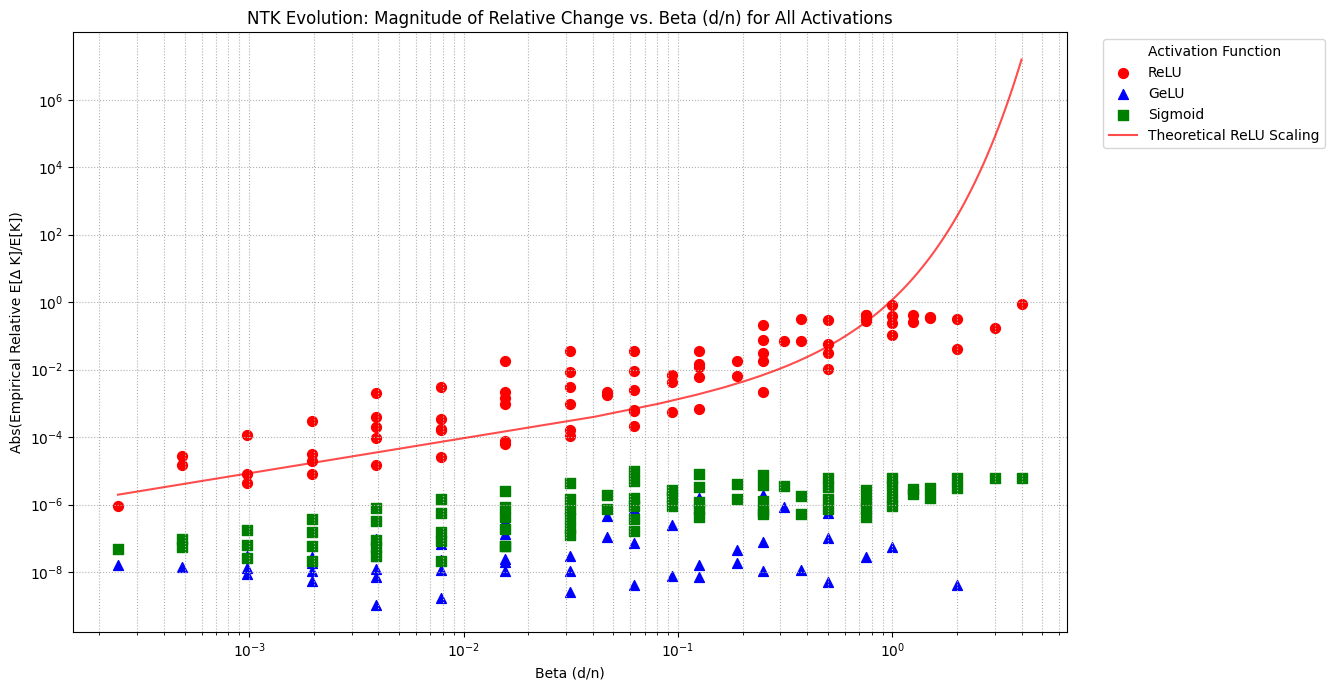

In [32]:
activation_styles = {
    "ReLU": {"color": "red", "marker": "o", "label": "ReLU"},
    "Gelu": {"color": "blue", "marker": "^", "label": "GeLU"},
    "Sigmoid_like": {"color": "green", "marker": "s", "label": "Sigmoid"}
}

plot_data_delta_k = plot_df_delta_k.copy()

plot_data_delta_k['depth'] = plot_data_delta_k['config_name'].str.extract(r'D(\d+)_W(\d+)').iloc[:, 0].astype(float)
plot_data_delta_k['width'] = plot_data_delta_k['config_name'].str.extract(r'D(\d+)_W(\d+)').iloc[:, 1].astype(float)

# Extract input dimension (n0) from config_details if available, or assume a default (e.g., 1 if not specified)
plot_data_delta_k['n0'] = plot_data_delta_k['config_details'].apply(
    lambda x: x.get('INPUT_DIM', 1) if isinstance(x, dict) else 1
).astype(float)

# Compute beta = d/n for each configuration
plot_data_delta_k['beta'] = plot_data_delta_k.apply(
    lambda row: row['depth'] / row['width'] if row['depth'] is not None and row['width'] is not None and row['width'] != 0 else None,
    axis=1
)

# Filter out rows where beta or emp_relative_delta_K is None or NaN
plot_data_delta_k = plot_data_delta_k.dropna(subset=['beta', 'emp_relative_delta_K'])

# Sort by beta for consistent plotting
plot_data_delta_k = plot_data_delta_k.sort_values(by="beta")

# Extract plot values
beta_values = jnp.asarray(plot_data_delta_k["beta"].values)
y_plot_values_dk_abs = jnp.abs(jnp.asarray(plot_data_delta_k["emp_relative_delta_K"].values))
config_names_dk_plot = plot_data_delta_k["config_name"].values
activation_names_dk = plot_data_delta_k["activation_name"].values
depth_values = jnp.asarray(plot_data_delta_k["depth"].values)
n0_values = jnp.asarray(plot_data_delta_k["n0"].values)

# Filter for valid log-scale values (positive and non-zero)
valid_log_indices_beta = beta_values > 1e-9
valid_log_indices_y = y_plot_values_dk_abs > 1e-9
valid_log_indices = valid_log_indices_beta & valid_log_indices_y

beta_final = beta_values[valid_log_indices]
y_plot_final_dk = y_plot_values_dk_abs[valid_log_indices]
names_final_dk = config_names_dk_plot[valid_log_indices]
activations_final_dk = activation_names_dk[valid_log_indices]
depth_final = depth_values[valid_log_indices]
n0_final = n0_values[valid_log_indices]

plt.figure(figsize=(15, 7))

# Plot empirical data for each activation function
for activation in activation_styles.keys():
    # Filter data for the current activation
    mask = activations_final_dk == activation
    if not jnp.any(mask):
        print(f"No valid data for activation {activation}")
        continue

    beta_activation = beta_final[mask]
    y_activation = y_plot_final_dk[mask]
    names_activation = names_final_dk[mask]

    # Plot scatter points with specified style
    style = activation_styles.get(activation, {"color": "black", "marker": ".", "label": activation})
    plt.scatter(beta_activation, y_activation, 
                color=style["color"], marker=style["marker"], label=style["label"], s=50)

    # Annotate points with config names -> this makes it not very readable
    # for i, txt in enumerate(names_activation):
    #     plt.annotate(txt, (beta_activation[i], y_activation[i]),
    #                  textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

# Plot theoretical curve for ReLU: (d * beta / n_0) * exp(5 * beta)
# Generate a range of beta values for the theoretical curve
beta_range = jnp.linspace(beta_final.min(), beta_final.max(), 100)
# Use median values from ReLU configurations for consistency
relu_mask = activations_final_dk == "ReLU"
if jnp.any(relu_mask):
    median_depth = jnp.median(depth_final[relu_mask])
    median_n0 = jnp.median(n0_final[relu_mask])
    theoretical_scaling = (median_depth * beta_range / median_n0) * jnp.exp(5 * beta_range) * learning_rate_sgd
    plt.plot(beta_range, theoretical_scaling, 'r-', label=f'Theoretical ReLU Scaling', alpha=0.7) # (d*beta/n0)exp(5*beta)

# Configure plot settings
plt.xlabel("Beta (d/n)")
plt.ylabel("Abs(Empirical Relative E[∆ K]/E[K])")
plt.title("NTK Evolution: Magnitude of Relative Change vs. Beta (d/n) for All Activations")
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', title="Activation Function")
plt.grid(True, which="both", linestyle=':')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()